In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

# Load Dataset

(17998, 96, 96) (17998, 4)
(6000, 96, 96) (6000, 4)


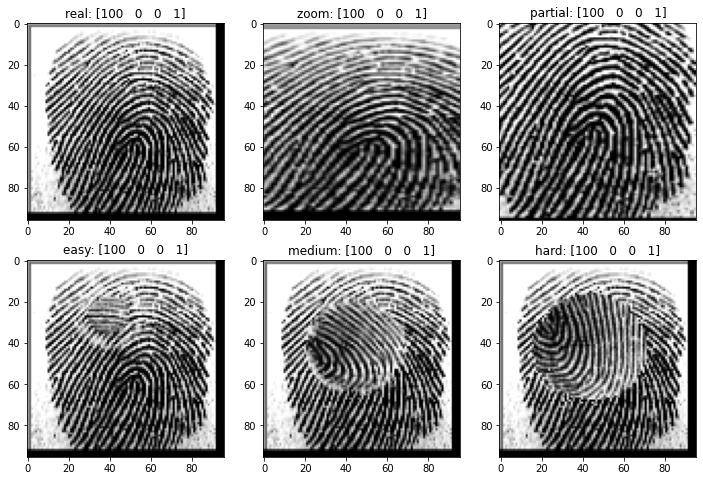

In [2]:
x_real = np.load('dataset/x_real.npz')['data']
y_real = np.load('dataset/y_real.npy')
x_easy = np.load('dataset/x_easy.npz')['data']
y_easy = np.load('dataset/y_easy.npy')
x_medium = np.load('dataset/x_medium.npz')['data']
y_medium = np.load('dataset/y_medium.npy')
x_hard = np.load('dataset/x_hard.npz')['data']
y_hard = np.load('dataset/y_hard.npy')
x_zoom = np.load('dataset/x_zoom.npz')['data']
y_zoom = np.load('dataset/y_zoom.npy')
x_partial = np.load('dataset/x_partial.npz')['data']
y_partial = np.load('dataset/y_partial.npy')

print(x_zoom.shape, y_zoom.shape)
print(x_partial.shape, y_partial.shape)

n = 0
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.title('real: %s' %y_real[n])
plt.imshow(x_real[n].squeeze(), cmap='gray')
plt.subplot(2, 3, 2)
plt.title('zoom: %s' %y_zoom[n])
plt.imshow(x_zoom[n].squeeze(), cmap='gray')
plt.subplot(2, 3, 3)
plt.title('partial: %s' %y_partial[n])
plt.imshow(x_partial[n].squeeze(), cmap='gray')
plt.subplot(2, 3, 4)
plt.title('easy: %s' %y_easy[n])
plt.imshow(x_easy[n].squeeze(), cmap='gray')
plt.subplot(2, 3, 5)
plt.title('medium: %s' %y_medium[n])
plt.imshow(x_medium[n].squeeze(), cmap='gray')
plt.subplot(2, 3, 6)
plt.title('hard: %s' %y_hard[n])
plt.imshow(x_hard[n].squeeze(), cmap='gray')

# Make Label Dictionary Lookup Table

In [3]:
# ID(3)性別(1)左右(1)指頭(1): index
# {'100001': 0, '100004': 1, '100002': 2, ....}
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

# Data Generator

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 96, 96), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.
        
        #return [x1_batch.reshape(*x1_batch,1).astype(np.float32) / 255., x2_batch.reshape(*x2_batch,1).astype(np.float32) / 255.], y_batch
        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

# load model

In [5]:
# model =  keras.models.load_model('./data/fingerprint_220727.h5')
# model =  keras.models.load_model('./data/Siamese_zoom_0.91.h5')
# model =  keras.models.load_model('./data/Siamese_zoom_0.95.h5')
model =  keras.models.load_model('./data/Siamese_zoom_0.99.h5')

# Evaluation

In [8]:
# 評估模型 Real
test_real_gen = DataGenerator(x_real, y_real, x_real, label_real_dict, shuffle=False)
print('\nTesting ...')
loss, accuracy = model.evaluate(test_real_gen, verbose=1)
print('Real測試資料集的準確度 = {:.2f}'.format(accuracy))


Testing ...
187/187 [==============================] - 8s 45ms/step - loss: 0.0045 - acc: 0.9983
Real測試資料集的準確度 = 1.00


In [9]:
# 評估模型 Partial
test_partial_gen = DataGenerator(x_partial, y_partial, x_real, label_real_dict, shuffle=False)
print('\nTesting ...')
loss, accuracy = model.evaluate(test_partial_gen, verbose=1)
print('Partial測試資料集的準確度 = {:.2f}'.format(accuracy))


Testing ...
187/187 [==============================] - 9s 45ms/step - loss: 0.1241 - acc: 0.9801
Partial測試資料集的準確度 = 0.98


In [15]:
# 評估模型 Easy
test_easy_gen = DataGenerator(x_easy, y_easy, x_real, label_real_dict, shuffle=False)
print('\nTesting ...')
loss, accuracy = model.evaluate(test_easy_gen, verbose=1)
print('Easy測試資料集的準確度 = {:.2f}'.format(accuracy))


Testing ...
560/560 [==============================] - 25s 45ms/step - loss: 0.3207 - acc: 0.9099
Easy測試資料集的準確度 = 0.91


In [16]:
# 評估模型 Medium
test_medium_gen = DataGenerator(x_medium, y_medium, x_real, label_real_dict, shuffle=False)
print('\nTesting ...')
loss, accuracy = model.evaluate(test_medium_gen, verbose=1)
print('Medium測試資料集的準確度 = {:.2f}'.format(accuracy))


Testing ...
533/533 [==============================] - 24s 45ms/step - loss: 1.0400 - acc: 0.7839
Medium測試資料集的準確度 = 0.78


In [17]:
# 評估模型 Hard
test_hard_gen = DataGenerator(x_hard, y_hard, x_real, label_real_dict, shuffle=False)
print('\nTesting ...')
loss, accuracy = model.evaluate(test_hard_gen, verbose=1)
print('Hard測試資料集的準確度 = {:.2f}'.format(accuracy))


Testing ...
446/446 [==============================] - 20s 45ms/step - loss: 2.0964 - acc: 0.6738
Hard測試資料集的準確度 = 0.67
